In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [27]:
base_df = pd.read_csv("data/base_df.csv")

In [28]:
base_df.head()

,CLIENT_ID,AGE,MAN,INCOME,IP_FLAG,SME_FLAG,REFUGEE_FLAG,PDN,paid_off_count,active_count,...,credits_delay_count,cards_count,cards_delay_count,MATRIAL_Вдовец / Вдова,MATRIAL_Гражданский брак,MATRIAL_Женат / замужем,MATRIAL_Не женат / не замужем,MATRIAL_Неизвестно,MATRIAL_Разведен / Разведена,DELAY
0,22,37,1,105000,0,0,0,60.8,0,0,...,0,1,0,0,0,0,0,1,0,False
1,23,33,1,80000,0,0,0,8.4,0,1,...,0,0,0,0,0,0,1,0,0,False
2,49,47,0,40000,0,0,0,82.4,0,0,...,0,1,0,0,0,0,1,0,0,False
3,53,36,0,35000,0,0,0,118.5,0,0,...,0,1,0,0,0,0,0,1,0,False
4,55,43,0,100000,0,0,0,49.8,0,0,...,0,1,0,0,0,1,0,0,0,False


In [29]:
X = base_df.drop(columns=['DELAY', 'CLIENT_ID'])
y = base_df.DELAY

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4272, 20) (2849, 20) (4272,) (2849,)


Дерево

In [30]:
%%time
dt_selector = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": range(1, 17),
        "min_samples_split": range(2, 17),
        "min_samples_leaf": range(1, 17),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
    n_iter=128,
)

dt_selector.fit(X_train, y_train)

print(dt_selector.best_estimator_.score(X_train, y_train),
      dt_selector.best_estimator_.score(X_test, y_test))

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
0.9995318352059925 0.9989469989469989
CPU times: total: 781 ms
Wall time: 4.73 s


In [31]:
dt_selector.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=14, min_samples_leaf=3,
                       min_samples_split=16, random_state=42)

In [32]:
dt = DecisionTreeClassifier(random_state=42,
                            max_depth=2,
                            criterion="entropy")

dt.fit(X_train, y_train)
print(f"Train: {dt.score(X_train, y_train):.10f} | Test: {dt.score(X_test, y_test):.10f}")

Train: 0.9995318352 | Test: 0.9989469989


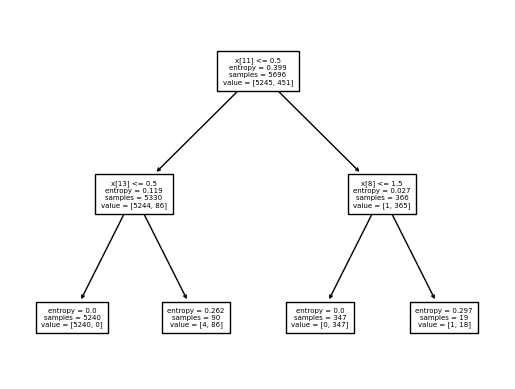

In [20]:
plot_tree(dt, fontsize=5);

In [ ]:
pd.DataFrame({'Feature': X_train.columns, 'Importance': dt.feature_importances_}).sort_values(by='Importance', ascending=False).head(10)

Лес

In [ ]:
%%time
rf_selector = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, max_depth=6, criterion='entropy'),
    {
        #"criterion": ["gini", "entropy", "log_loss"],
        #"max_depth": range(1, 17),
        "n_estimators": range(8, 1024 + 1),
    },
    cv=5,
    n_jobs=-1,
    verbose=2,
    n_iter=16,
)

rf_selector.fit(X_train, y_train)

print(rf_selector.best_estimator_.score(X_train, y_train),
      rf_selector.best_estimator_.score(X_test, y_test))

In [ ]:
rf_selector.best_estimator_

In [23]:
rf = RandomForestClassifier(random_state=42,
                            max_depth=6,
                            n_estimators=1000,
                            criterion="entropy")

rf.fit(X_train, y_train)
print(f"Train: {rf.score(X_train, y_train):.10f} | Test: {rf.score(X_test, y_test):.10f}")

Train: 0.9991221910 | Test: 1.0000000000


In [24]:
pd.DataFrame(
    data=rf.feature_importances_,
    index=list(X),
    columns=["weight"]
).sort_values("weight", ascending=False).head(10)

,weight
credits_delay_count,0.558173
cards_delay_count,0.168435
paid_off_count,0.100991
max_term,0.044002
cards_count,0.027065
MATRIAL_Неизвестно,0.022905
active_sum,0.020596
active_count,0.018230
PDN,0.008634
AGE,0.007841


xgb

In [ ]:
%%time
xg_selector = GridSearchCV(
    XGBClassifier(random_state=42, max_depth=2),
    {
        #"max_depth": range(1, 17),
        "n_estimators": range(90, 120),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

xg_selector.fit(X_train, y_train)

print(xg_selector.best_estimator_.score(X_train, y_train),
      xg_selector.best_estimator_.score(X_test, y_test))

In [33]:
xgc = XGBClassifier(random_state=42, max_depth=2, n_estimators=113)
xgc.fit(X_train, y_train)

print(xgc.score(X_train, y_train), xgc.score(X_test, y_test))

0.9995318352059925 0.9989469989469989


cb

In [ ]:
%%time
cb_selector = GridSearchCV(
    CatBoostClassifier(random_state=42, verbose=0, iterations=256),
    {
        #"max_depth": range(1, 17),
        #"n_estimators": range(90, 120),
        "depth": range(2, 11),
    },
    cv=10,
    n_jobs=-1,
    verbose=2,
)

cb_selector.fit(X_train, y_train)

print(cb_selector.best_estimator_.score(X_train, y_train),
      cb_selector.best_estimator_.score(X_test, y_test))

In [ ]:
cb = CatBoostClassifier(iterations=500, depth=5, verbose=0)
cb.fit(X_train, y_train)

print(cb.score(X_train, y_train), cb.score(X_test, y_test))

In [ ]:
cb_selector.best_estimator_.get_all_params()

In [ ]:
for lim in np.linspace(0.46, 0.52, 11):
    pred = []
    for f, t in xgc.predict_proba(X_test):
        if f > lim:
            pred.append(0)
        else:
            pred.append(1)

    print(f"{lim:.5f} | {accuracy_score(pred, y_test):.10f}")

In [ ]:
xgc.predict_proba(X_test)

In [ ]:
xgc.predict(X_test.iloc[29:30])

In [ ]:
y_test[20:40]

In [ ]:
X_test.iloc[29:30].T

In [ ]:
xgc.predict(X_test.iloc[20:40])

In [35]:
joblib.dump(xgc, 'params/xgb_model.joblib')

['params/xgb_model.joblib']

In [36]:
joblib.dump(dt, 'params/dt_model.joblib')

['params/dt_model.joblib']

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AGE                            7121 non-null   int64  
 1   MAN                            7121 non-null   int64  
 2   INCOME                         7121 non-null   int64  
 3   IP_FLAG                        7121 non-null   int64  
 4   SME_FLAG                       7121 non-null   int64  
 5   REFUGEE_FLAG                   7121 non-null   int64  
 6   PDN                            7121 non-null   float64
 7   paid_off_count                 7121 non-null   int64  
 8   active_count                   7121 non-null   int64  
 9   active_sum                     7121 non-null   float64
 10  max_term                       7121 non-null   int64  
 11  credits_delay_count            7121 non-null   int64  
 12  cards_count                    7121 non-null   i